### Objective

The objective of this project is to develop a model that can predict the demand for shared bikes offered by BoomBikes in the US market. This model will be used to:

1. **Identify significant factors:** Understand which factors from the available data significantly impact the demand for shared bikes.
2. **Predict demand:** Predict the number of bike rentals based on the identified factors. This will help BoomBikes anticipate demand fluctuations and optimize their operations.
3. **Improve business strategy:** Use the insights from the model to develop a data-driven business strategy. This could involve strategically placing docking stations, adjusting pricing based on demand forecasts, and launching targeted marketing campaigns.
4. **Understand market dynamics:** Gain insights into the overall demand patterns for shared bikes in the US market. This knowledge can be valuable when entering new markets or expanding existing services.

By achieving these objectives, BoomBikes can:

* **Increase revenue:** By understanding and meeting customer demand more effectively.
* **Reduce costs:** By optimizing resource allocation based on predicted demand.
* **Gain a competitive edge:** By offering a service that is more responsive to customer needs.

Overall, this project aims to leverage data analysis to create a more informed and successful business model for BoomBikes in the post-pandemic US market.


In [328]:
#Import libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.metrics import r2_score

### Importing Excel.csv file

In [329]:
boom_bike = pd.read_csv("day.csv")
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
boom_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [330]:
def columns_DataFrame(dataFrame, null_check_percentage):
    """
    To analyze the number of columns in a pandas DataFrame that have a percentage
    of null values exceeding a specified threshold.

    Args:
        dataFrame (pandas.DataFrame): The pandas DataFrame to be analyzed.
        null_check_percentage (float): The percentage threshold for null values in columns.
        Columns with a percentage of null values exceeding this threshold will be counted.

    Returns:
        missing_Column_Count (int): An integer representing the number of columns in
        the DataFrame that have a percentage of null values greater than the
        null_check_percentage parameter.
    """
    missing_Column_Count = sum(round(100 * dataFrame[col].isnull().mean(), 2
                                    ) > null_check_percentage
                               for col in dataFrame.columns)
    return missing_Column_Count


def dataFrame_properties(dataFrame, null_check_percentage):
    """
    The dataFrame_properties function is designed to analyze and report on various
    properties of a pandas DataFrame, including its shape, column data types,
    descriptive statistics, null value distribution, and columns exceeding
    a user-specified null value threshold.

    Args:
        dataFrame (pandas.DataFrame): The pandas DataFrame you want to analyze.
        null_check_percentage (float): The percentage threshold for null values
                                       in columns.Columns with a percentage of
                                       null values exceeding this threshold will
                                       be identified.
    Returns:
        The function primarily prints the analysis results to the console.
        However, it indirectly modifies the DataFrame by potentially dropping columns
        with excessive null values (depending on how the function is used).
    """
    star = 20
    print('*' * star, 'DataFrame Shape', '*' * star)
    print(dataFrame.shape,'\n')
    print('*' * star, 'DataFrame Top Five Records', '*' * star)
    print(dataFrame.head())
    print('*' * star, 'DataFrame Column Types', '*' * star)
    print(dataFrame.dtypes,'\n')
    print('*' * star, 'DataFrame distribution summary', '*' * star)
    print(dataFrame.describe(),'\n')
    print('*' * star, 'DataFrame Null Check greater than', null_check_percentage,
          '%', '*' * star)
    series_Null_Check_User_Input = round(dataFrame.isnull().mean() * 100, 2)
    print(series_Null_Check_User_Input[series_Null_Check_User_Input >
          null_check_percentage],'\n')
    print('*' * star, 'DataFrame Null Info', '*' * star)
    print(dataFrame.isnull().sum(),'\n')
    print('*' * star, 'DataFrame Shape of Null Check greater than',
          null_check_percentage, '%', '*' * star)
    missing_Column_Result =  columns_DataFrame(dataFrame, null_check_percentage)
    print('For',null_check_percentage, '% check we are having', missing_Column_Result,
          'columns in the data set','\n')
    print('*' * star, 'Later Dropping columns more than', null_check_percentage,
          '% from the DataFrame', '*' * star)
    print('Final Count of shape of DataFrame', dataFrame.shape[1] -
          missing_Column_Result, 'columns', '\n')

### Call dataFrame_properties function to fetch the dataframe details

In [331]:
dataFrame_properties(boom_bike, null_check_percentage = 50)

******************** DataFrame Shape ********************
(730, 16) 

******************** DataFrame Top Five Records ********************
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit   temp  atemp    hum  windspeed  casual  registered   cnt  
0           2 14.111 18.181 80.583     10.750     331         654   985  
1           2 14.903 17.687 69.609     16.652     131         670   801  
2           1  8.051  9.470 43.727     16.637     120        1229  1349  
3           1  8.200 10.606 59.044     10.740     108        1454  1562  
4           1  9.305 11.463 43.696     12.522 

### Unique Value in Columns

In [332]:
def drop_single_value_columns(data_frame):
    """
    Drops columns from a DataFrame that have only one unique value.

    Args:
        data_frame: The pandas DataFrame to modify.

    Returns:
        The modified DataFrame with columns having a single unique value dropped.
    """

    # Get the number of unique values for each column
    unique_values = data_frame.nunique()

    # Sort the unique value counts (optional)
    unique_values.sort_values(inplace=True)

    # Select columns with only one unique value
    list_columns_unique_values = unique_values[unique_values == 1]
    columns_to_drop = list_columns_unique_values.index.tolist()
    print(list_columns_unique_values)

    # Drop the identified columns
    data_frame.drop(columns_to_drop, axis=1, inplace=True)

    # Return the modified DataFrame
    return data_frame

In [333]:
#Updated DataFrame
boom_bike = drop_single_value_columns(boom_bike)
print('\n',boom_bike.shape)

Series([], dtype: int64)

 (730, 16)


* **Result:** Unique values in the data set

### Check for Duplicate

In [334]:
df_duplicate = boom_bike
df_duplicate.drop_duplicates(subset=None, inplace=True)
print(df_duplicate.shape)
print(boom_bike.shape)

(730, 16)
(730, 16)


* **Result:** Both duplicate dataframe and orginal dataframe are having same shape so no duplicate records are present in the data set.

### Building a Multiple Linear Regression Model for Bike Rentals

To build a multiple linear regression model for bike rentals, we need to identify the independent variables (predictors) that likely influence the dependent variable, which in this case is `cnt` (the count of total rental bikes including both casual and registered users).

**Dependent Variable:**

* `cnt`: This is the target variable that we are trying to predict.

**Independent Variables:**

The following columns from the dataset will be considered as independent variables based on the data dictionary:

* `yr`: Year (0: 2018, 1: 2019). This might be important as demand might increase over time.
* `mnth`: Month (1 to 12). This will help capture seasonality effects.
* `weekday`: Day of the week. This can capture weekly patterns in bike rentals.
* `season`: Season (1: Spring, 2: Summer, 3: Fall, 4: Winter). This needs to be converted to categorical values.
* `weathersit`: Weather situation (1: Clear, Few clouds, Partly cloudy; 2: Mist + Cloudy, ... ; 4: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog). This needs to be converted to categorical values.
* `holiday`: Whether the day is a holiday or not (0: No, 1: Yes). This binary variable can capture the effect of holidays on bike demand.
* `workingday`: Whether the day is a working day (1: Yes, 0: No). This binary variable can capture the effect of weekends and holidays.
* `temperature`: Temperature in Celsius. Likely to have a strong impact on bike rentals.
* `adjtemperature`: Feeling temperature in Celsius. Could be an alternative to `temp` or used in combination.
* `hum`: Humidity level. This can affect comfort levels for biking.
* `windspeed`: Wind speed. Higher wind speeds might deter bike usage.

**Excluded Variables:**

* `instant`: Record index. This is just an identifier and has no predictive power.
* `dteday`: Date. The information here is already captured by `yr`, `mnth`, and `weekday`.
* `casual` and `registered`: These are part of the target variable `cnt` (total rentals) and should not be included as predictors in this model.

**Summary of Columns to Include:**

After converting categorical variables into dummy/indicator variables and potentially normalizing numerical variables, the columns to include in the regression model are:

* `yr` (categorical, converted to dummy variables)
* `mnth` (categorical, converted to dummy variables)
* `weekday` (categorical, converted to dummy variables)
* `season` (categorical, converted to dummy variables)
* `weathersit` (categorical, converted to dummy variables)
* `holiday` (binary)
* `workingday` (binary)
* `temperature` (numerical)
* `adjtemperature` (numerical)
* `hum` (numerical)
* `windspeed` (numerical)

### Dropping unwanted column

In [335]:
boom_bike.drop(['instant', 'dteday','casual','registered'], axis=1, inplace=True)
boom_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.111,18.181,80.583,10.750,985
1,1,0,1,0,0,0,2,14.903,17.687,69.609,16.652,801
2,1,0,1,0,1,1,1,8.051,9.470,43.727,16.637,1349
3,1,0,1,0,2,1,1,8.200,10.606,59.044,10.740,1562
4,1,0,1,0,3,1,1,9.305,11.463,43.696,12.522,1600


### Mapping the Categorical columns with values
* `season`: Season (1: Spring, 2: Summer, 3: Fall, 4: Winter). This needs to be converted to categorical values.

In [336]:
boom_bike['season'] = boom_bike['season'].map(
    {1:'spring', 2:'summer', 3:'fall', 4:'winter'})

* `yr`: Year (0: 2018, 1: 2019). This might be important as demand might increase over time.

In [337]:
boom_bike['yr'] = boom_bike['yr'].map({0:'2018',1:'2019'})

* `mnth`: Month (1 to 12). This will help capture seasonality effects.

In [338]:
boom_bike['mnth'] = boom_bike['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar',
                        4:'Apr', 5:'May', 6:'Jun',
                        7:'Jul', 8:'Aug', 9:'Sep',
                        10:'Oct', 11:'Nov', 12:'Dec'})

* `weekday`: Day of the week. This can capture weekly patterns in bike rentals.

In [339]:
boom_bike['weekday'] = boom_bike[
    'weekday'].map({0:'sunday',1:'monday',2:'tuesday',3:'wednesday',
                    4:'thursday',5:'friday',6:'saturday'})

* `weathersit`: Weather situation (1: Clear, Few clouds, Partly cloudy; 2: Mist + Cloudy, ... ; 4: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog). This needs to be converted to categorical values.

In [340]:
boom_bike['weathersit'] = boom_bike[
    'weathersit'].map({1:"clear",2:"mist & cloudy",3:"light rain & snow"
                       ,4:'heavy rain & snow'})

#### Renaming the columns

In [341]:
boom_bike.rename(columns={'temp': 'temperature','atemp': 'adjtemperature',
                          'yr':'year','mnth':'month','hum':'humidity',
                          'cnt':'count'},inplace=True)

#### Analysis on the data set

In [342]:
def bar_plot_withouthue (data_frame, x_axis, y_axis):
    """
    Creates bar plots on assigned columns.

    Args:
        data_frame: The pandas DataFrame containing the data for the plot.
        x_axis: x axis in the plot
        y_axis: y axis in the plot

    Returns:
        bar plot
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(ax=ax, data=data_frame,
                          x=x_axis,
                          y=y_axis)
    title = f"{y_axis.upper()} Vs {x_axis.upper()}"
    ax.set_title(title, fontsize=10, color='red')
    ax.set_ylabel(y_axis, fontsize=8, color='red')
    ax.set_xlabel(x_axis, fontsize=8, color='red')

    plt.show()
    #print(x_axis, y_axis)

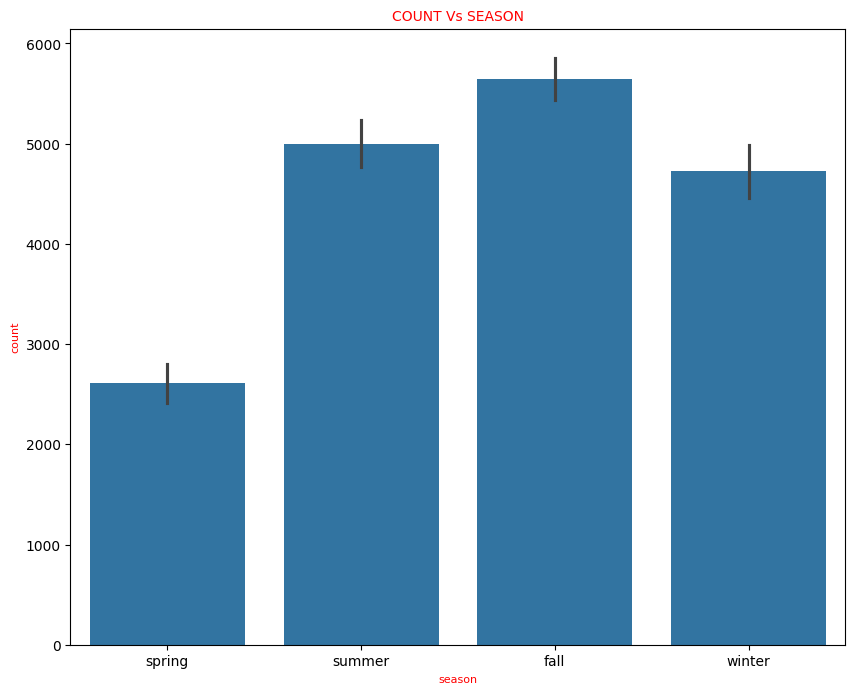

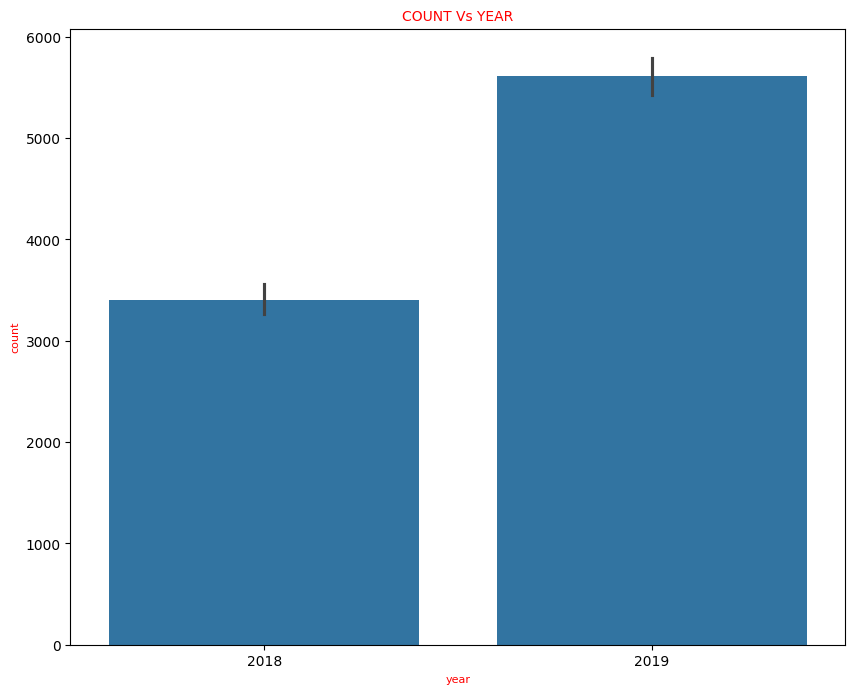

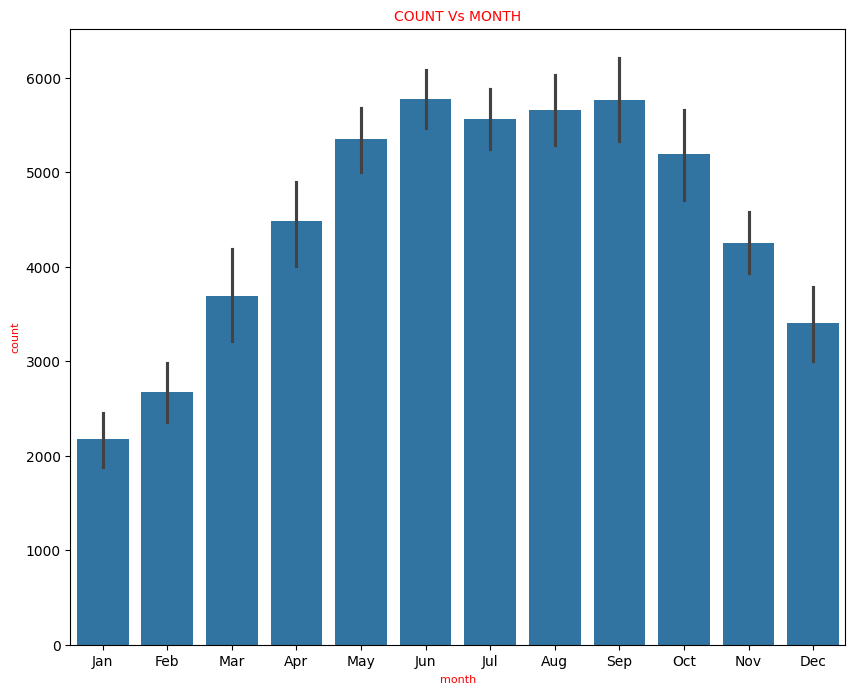

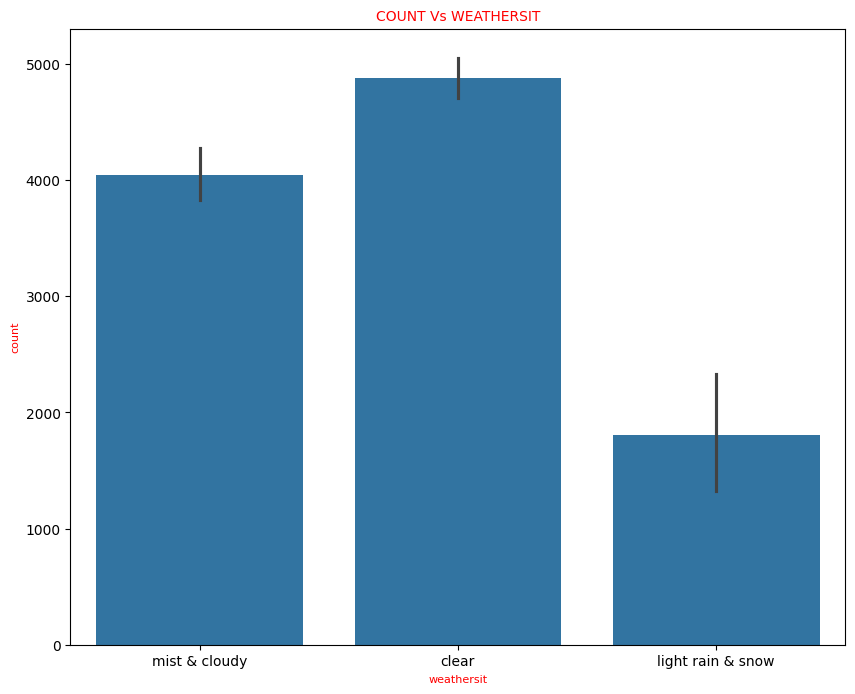

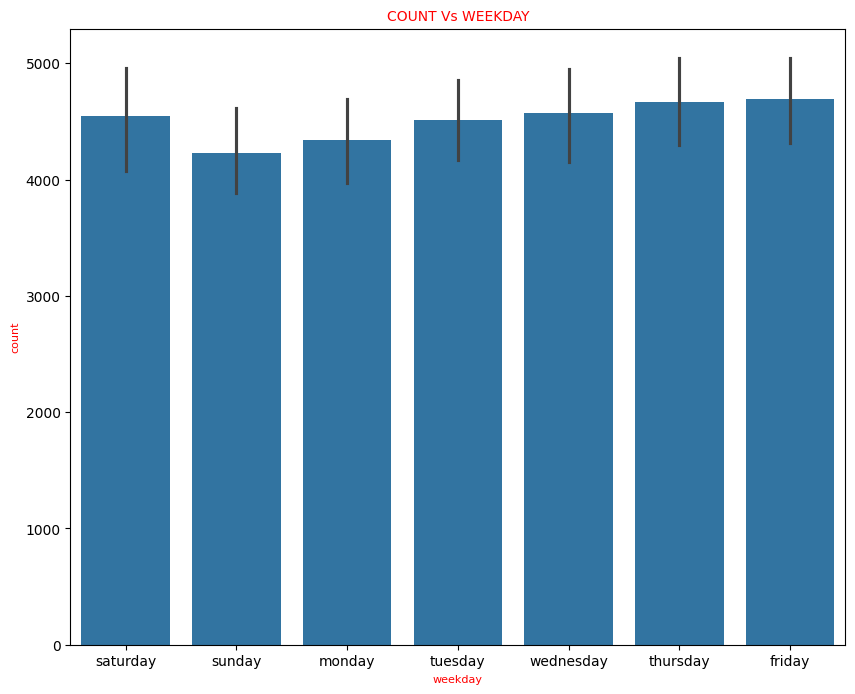

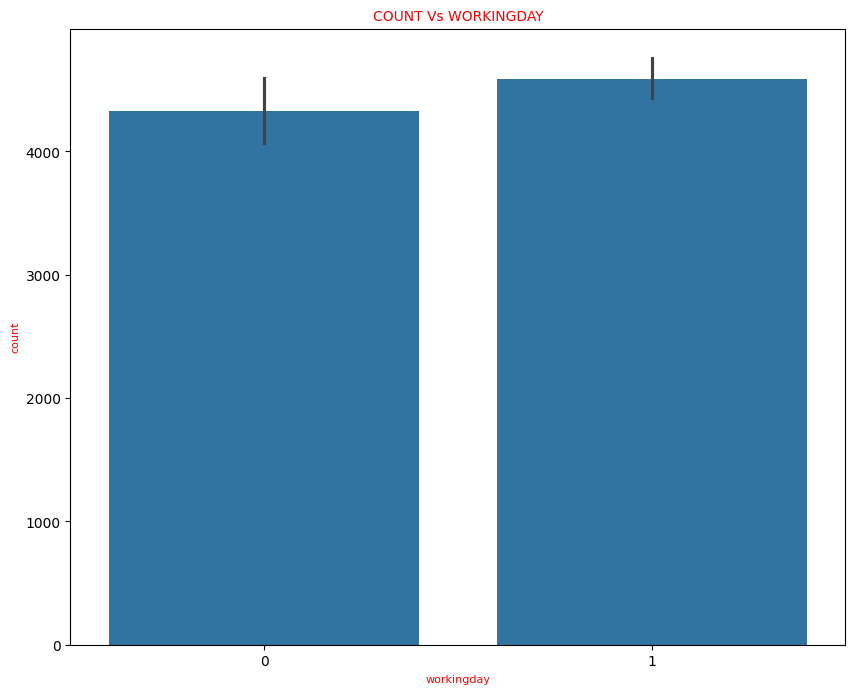

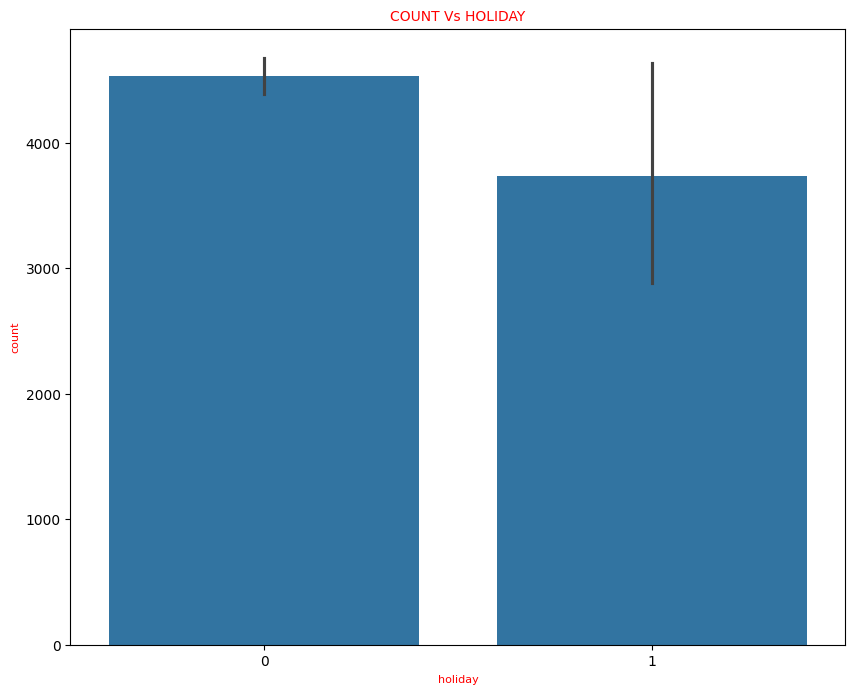

In [343]:
column_names = ['season', 'year', 'month', 'weathersit', 'weekday', 'workingday',
                'holiday']

for value in column_names:
    bar_plot_withouthue(boom_bike, value, 'count')

**Summary :**
1. `Season`: In Rainfall season customers booked more rental bike compare to other seasons
2. `Year`: In 2019 year company made good business compared to 2018 year
3. `Month`: In Sep month company had good business
4. `Weathersit`: In clear weather customer like to go for a ride
5. `Weekday`: In Friday & Saturday most of the customer like to take rental bike for a ride
6. `Workingday`: Most of bike booked in the workingday
7. `Holiday`: Most of the booking are in the non holiday days



In [344]:
def bar_plot_withhue (dataframe, x_axis, y_axis, hue_value):
    """
    Creates bar plots on assigned columns.

    Args:
        data_frame: The pandas DataFrame containing the data for the plot.
        x_axis: x axis in the plot
        y_axis: y axis in the plot
        hue_value: value which will differentiate the bars

    Returns:
        bar plot
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(ax=ax, data=dataframe, x=x_axis,
                y=y_axis, hue=hue_value)
    title = f"{y_axis.upper()} Vs {x_axis.upper()}"
    ax.set_title(title, fontsize=10, color='red')
    ax.set_ylabel(y_axis, fontsize=8, color='red')
    ax.set_xlabel(x_axis, fontsize=8, color='red')
    # Adjust x-offset (1.05) for better placement
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

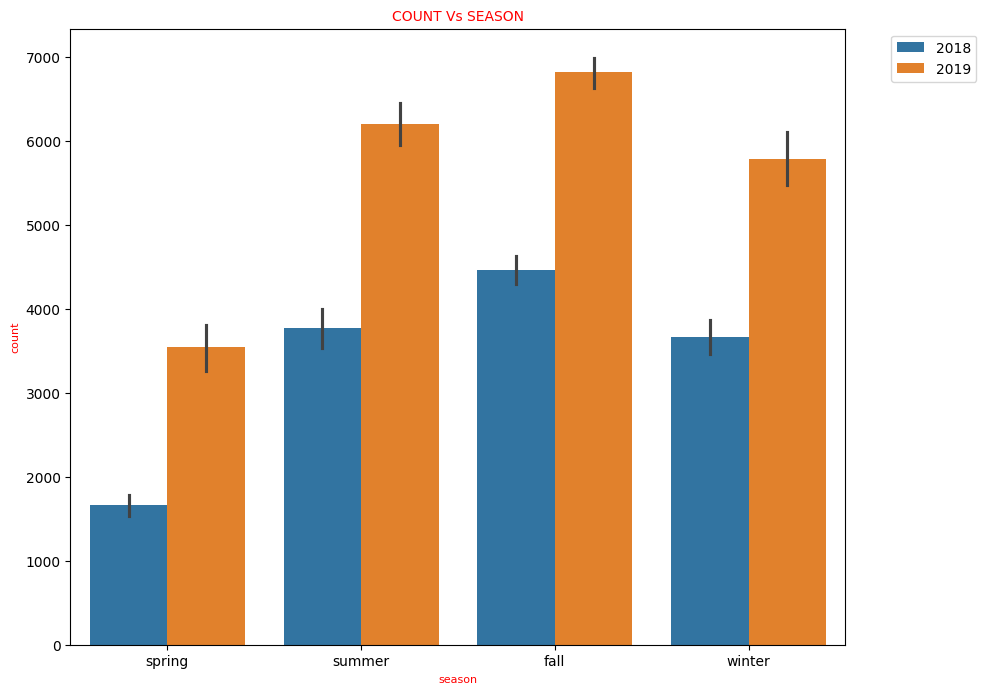

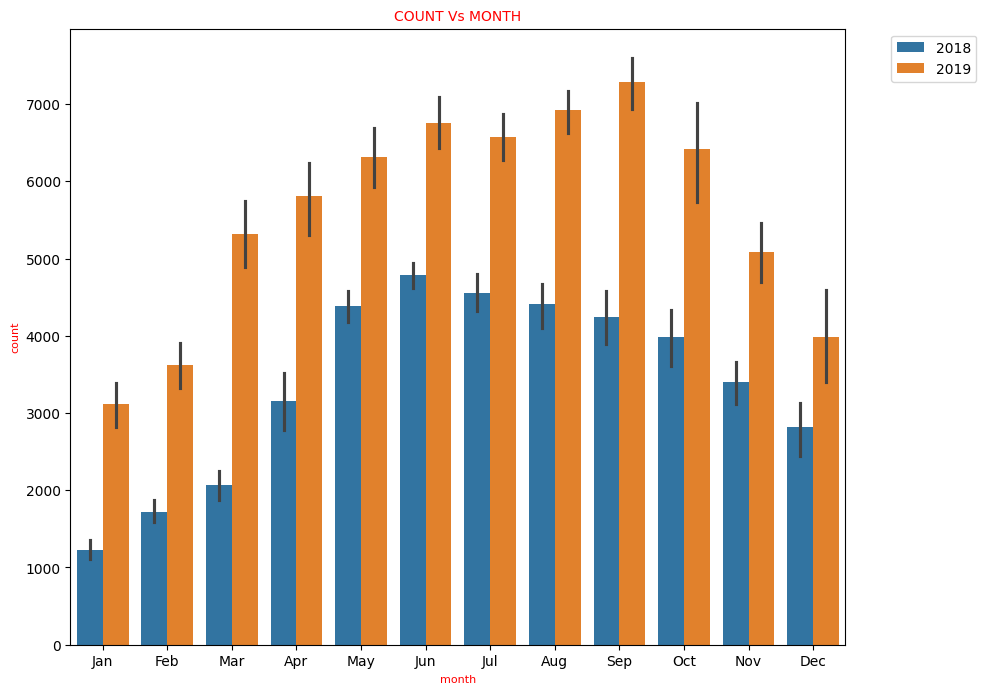

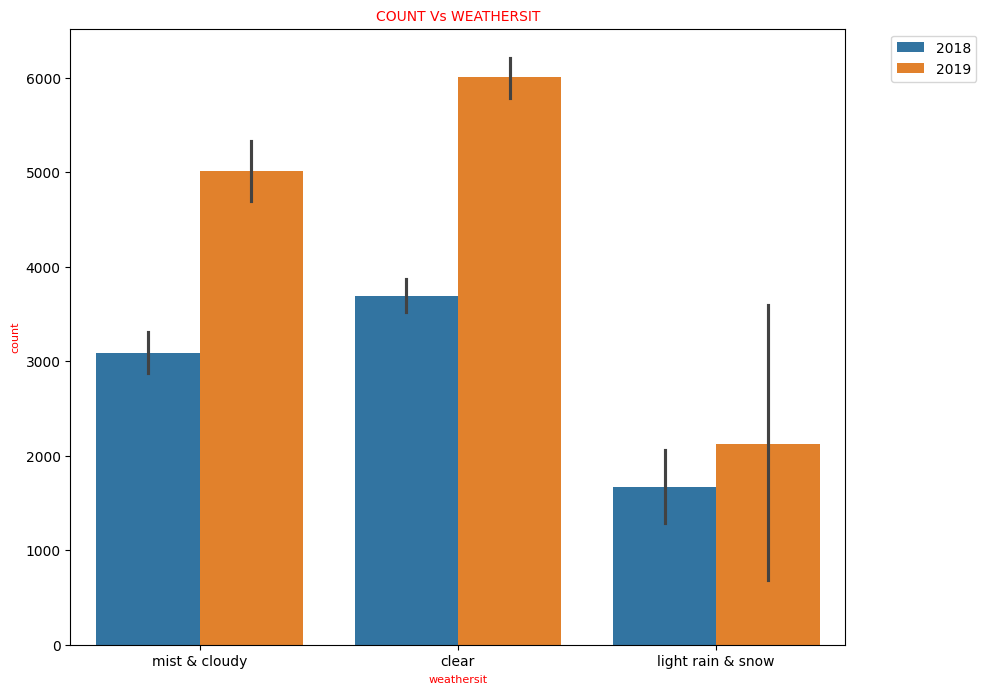

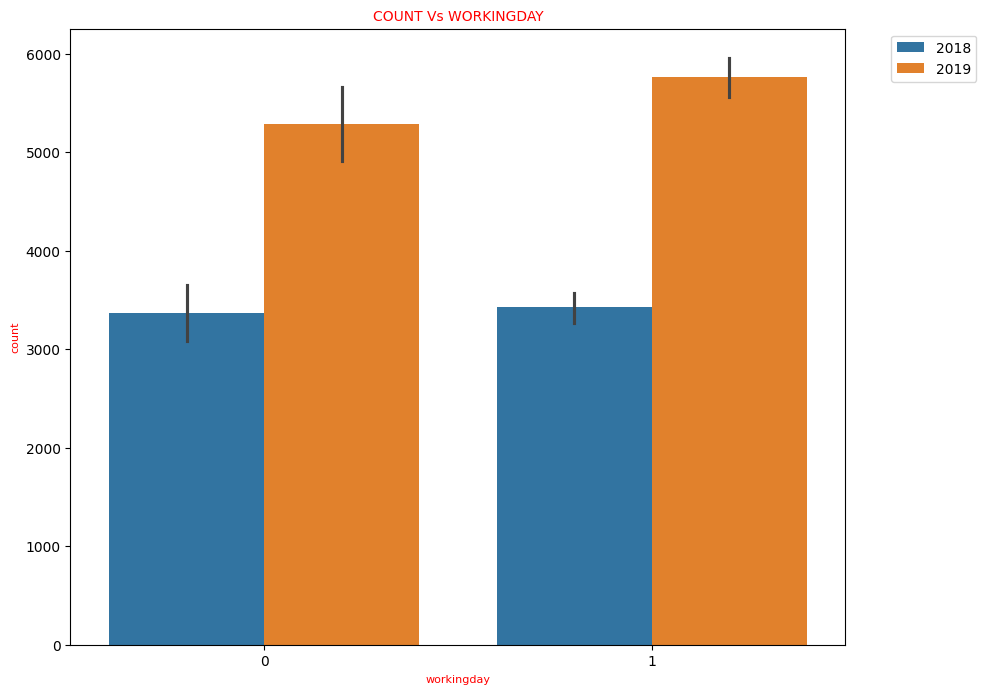

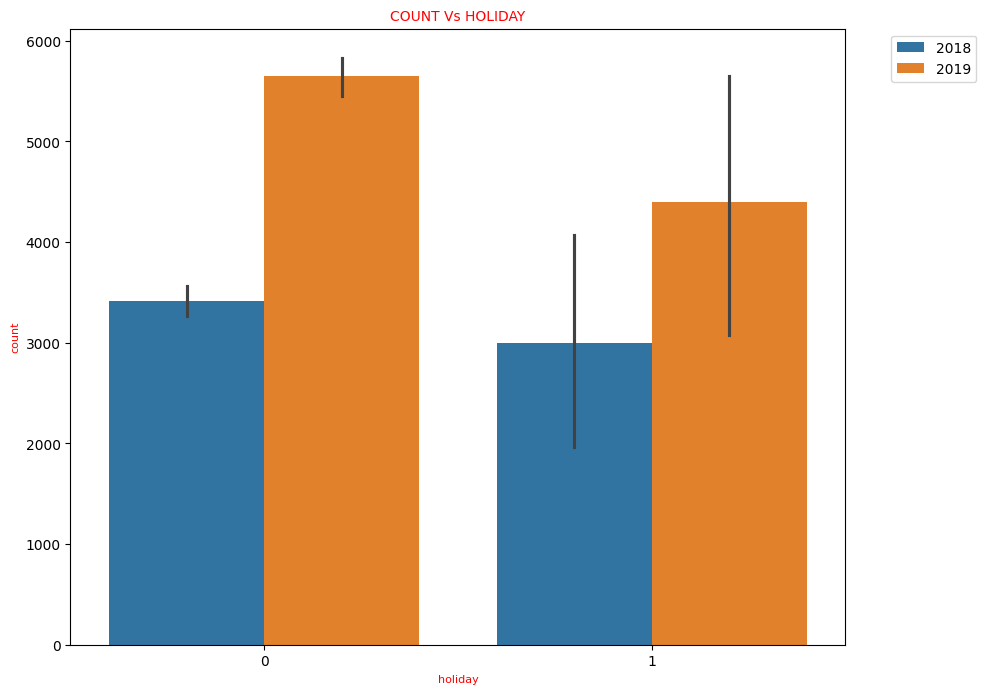

In [345]:
column_names = ['season', 'month', 'weathersit', 'workingday', 'holiday']

for value in column_names:
    bar_plot_withhue(boom_bike, value, 'count', 'year')

**Summay** - Year 2019 is having more bookings compare to 2018 year

1. `Season`: Fall season is the highest season in the bookings
2. `Month`: Sep month is the highest month in the bookings
3. `Weathersit`: Clear weather is the highest in the bookings
4. `Workingday`: Most of the bike is booked in the working days
5. `Holiday`: Most of the bookings are in non holiday compared to the holiday bookings



In [346]:
def box_plot (dataframe, x_axis, y_axis):
    """
    Creates box plots on assigned columns.

    Args:
        data_frame: The pandas DataFrame containing the data for the plot.
        x_axis: x axis in the plot
        y_axis: y axis in the plot

    Returns:
        bar plot
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(ax=ax, data=dataframe, x=x_axis,
                y=y_axis)
    title = f"{y_axis.upper()} Vs {x_axis.upper()}"
    ax.set_title(title, fontsize=10, color='red')
    ax.set_ylabel(y_axis, fontsize=8, color='red')
    ax.set_xlabel(x_axis, fontsize=8, color='red')
    plt.show()

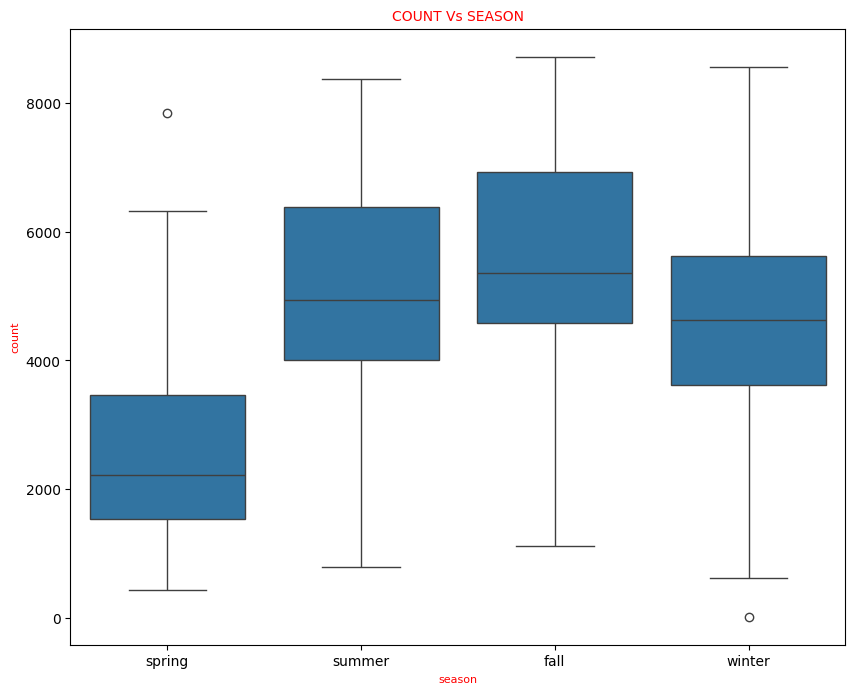

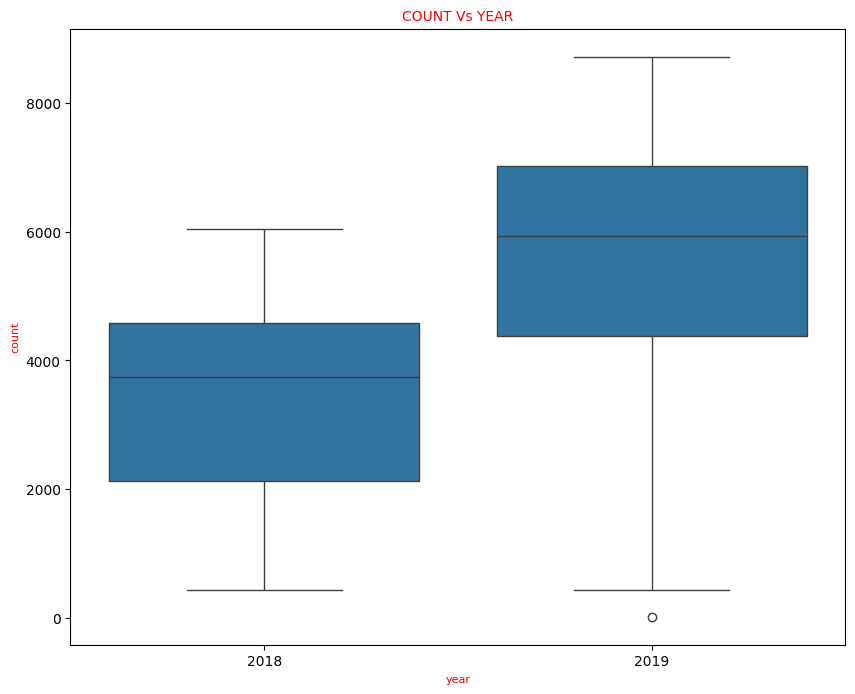

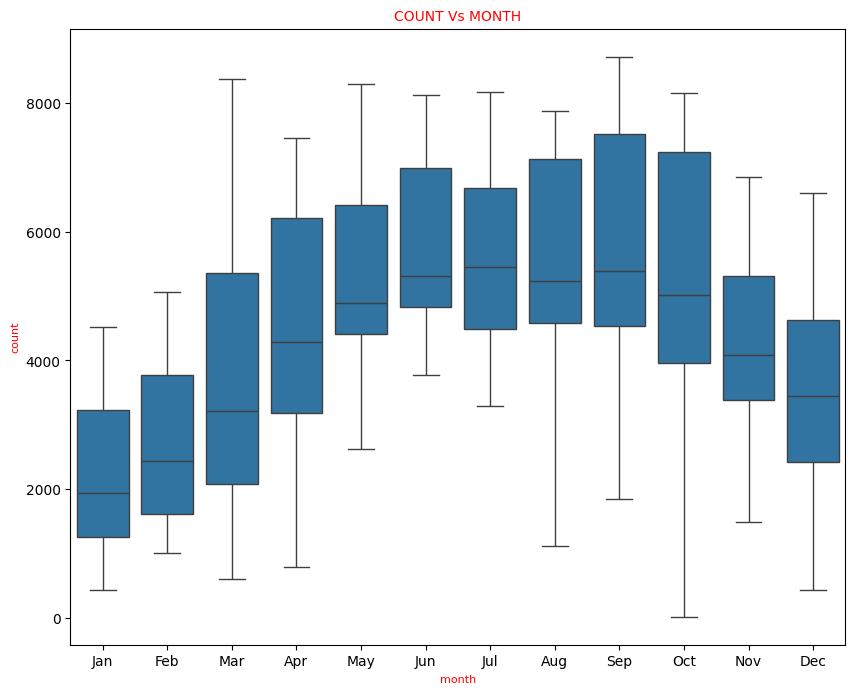

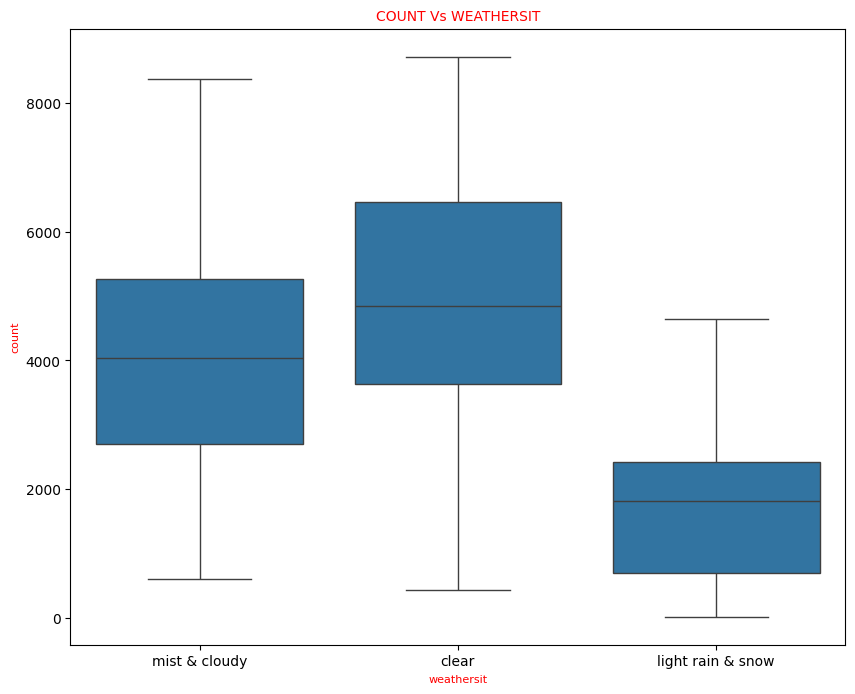

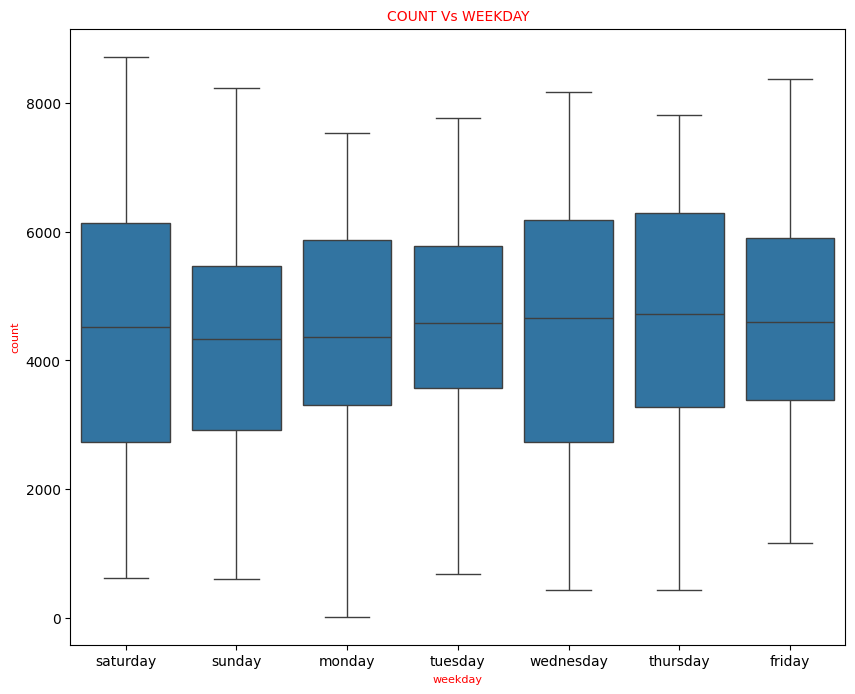

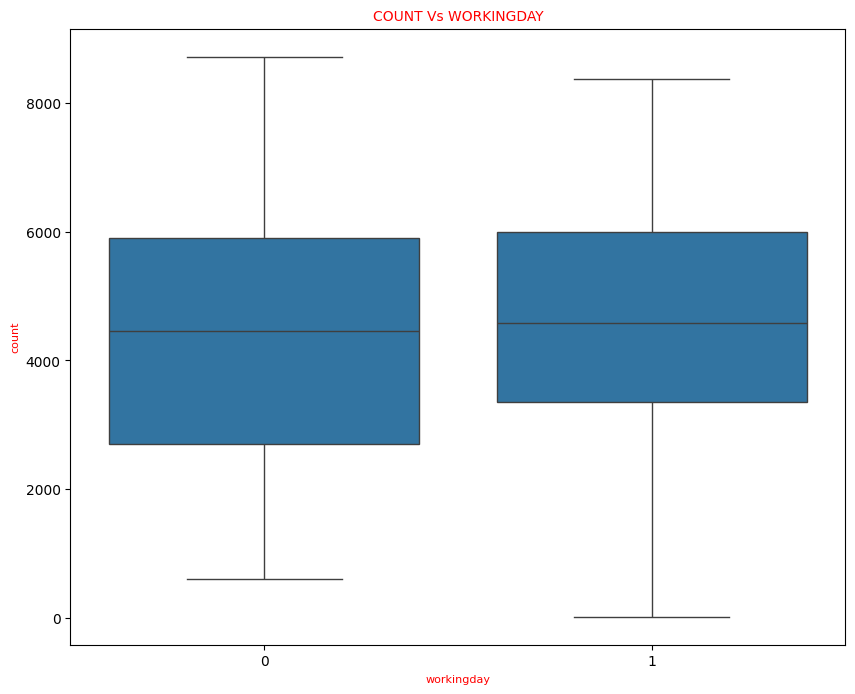

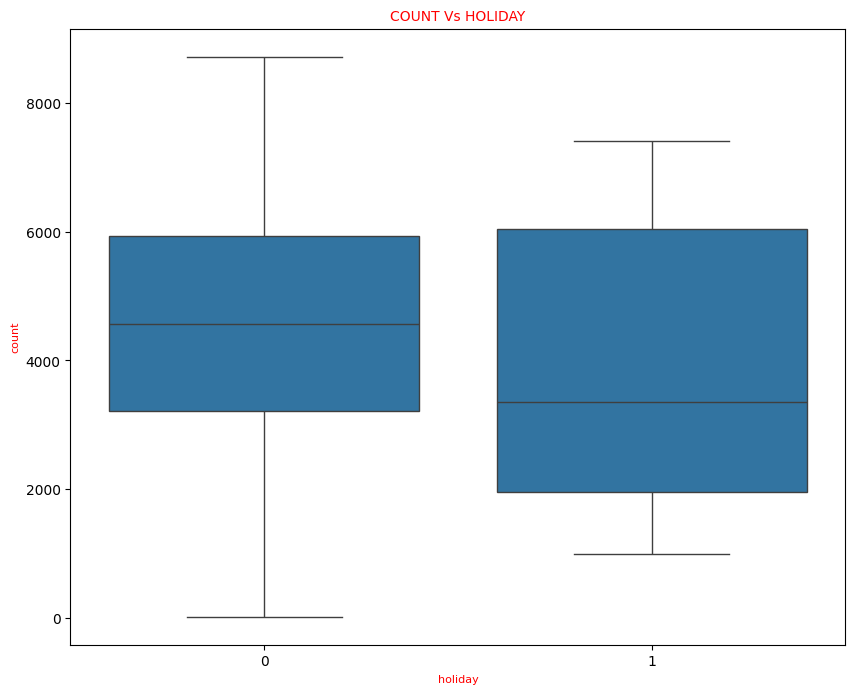

In [347]:
column_names = ['season', 'year', 'month', 'weathersit', 'weekday', 'workingday',
                'holiday']

for value in column_names:
    box_plot(boom_bike, value, 'count')

**Summary :**

1. `Seasons`: In 3rd season (fall) is having good number of booking, median is around 5,000 and in summer and winter seasons having decent number of bookings, This indicates, season can be a good predictor for the dependent variable
2. `Year`: In 2019 we are having good number of bookings, median is nearly  6000 Let model decide do we need to consider this variable or not
3. `Month`: From Apr to Oct month median number is more than 4,000, This indicates, month can be a good predictor for the dependent variable
4. `Weathersit`: Most of the booking are in the clear weather sit median number is nearly 5,000 and next mist & cloudy weather sit, this indicates, weather sit can be good predictor for the dependent variable
5. `Weekdays`: Weekday variable shows very close median over all the days, having their median between 4,000 and 5,000, This variable can have some or no influence towards the predictor.let the model decide if this needs to be added or not.
6. `Workingday`: most of the bike booking were happening in ‘workingday’ with a median close to 5,000.This indicates, workingday can be a good predictor for the dependent variable
7. `Holiday`: It seems most of the bookings in the holidays, So this variable will not make any impact to predict the model, let model decide if this needs to be added or not.



**Visualizing Pair Plot**

In [348]:
def pair_plot(dataframe):
    """
    Creates pair plots on assigned columns.

    Args:
        data_frame: The pandas DataFrame containing the data for the plot.

    Returns:
        pair plot
    """
    sns.pairplot(dataframe, diag_kind='kde')
    plt.show()

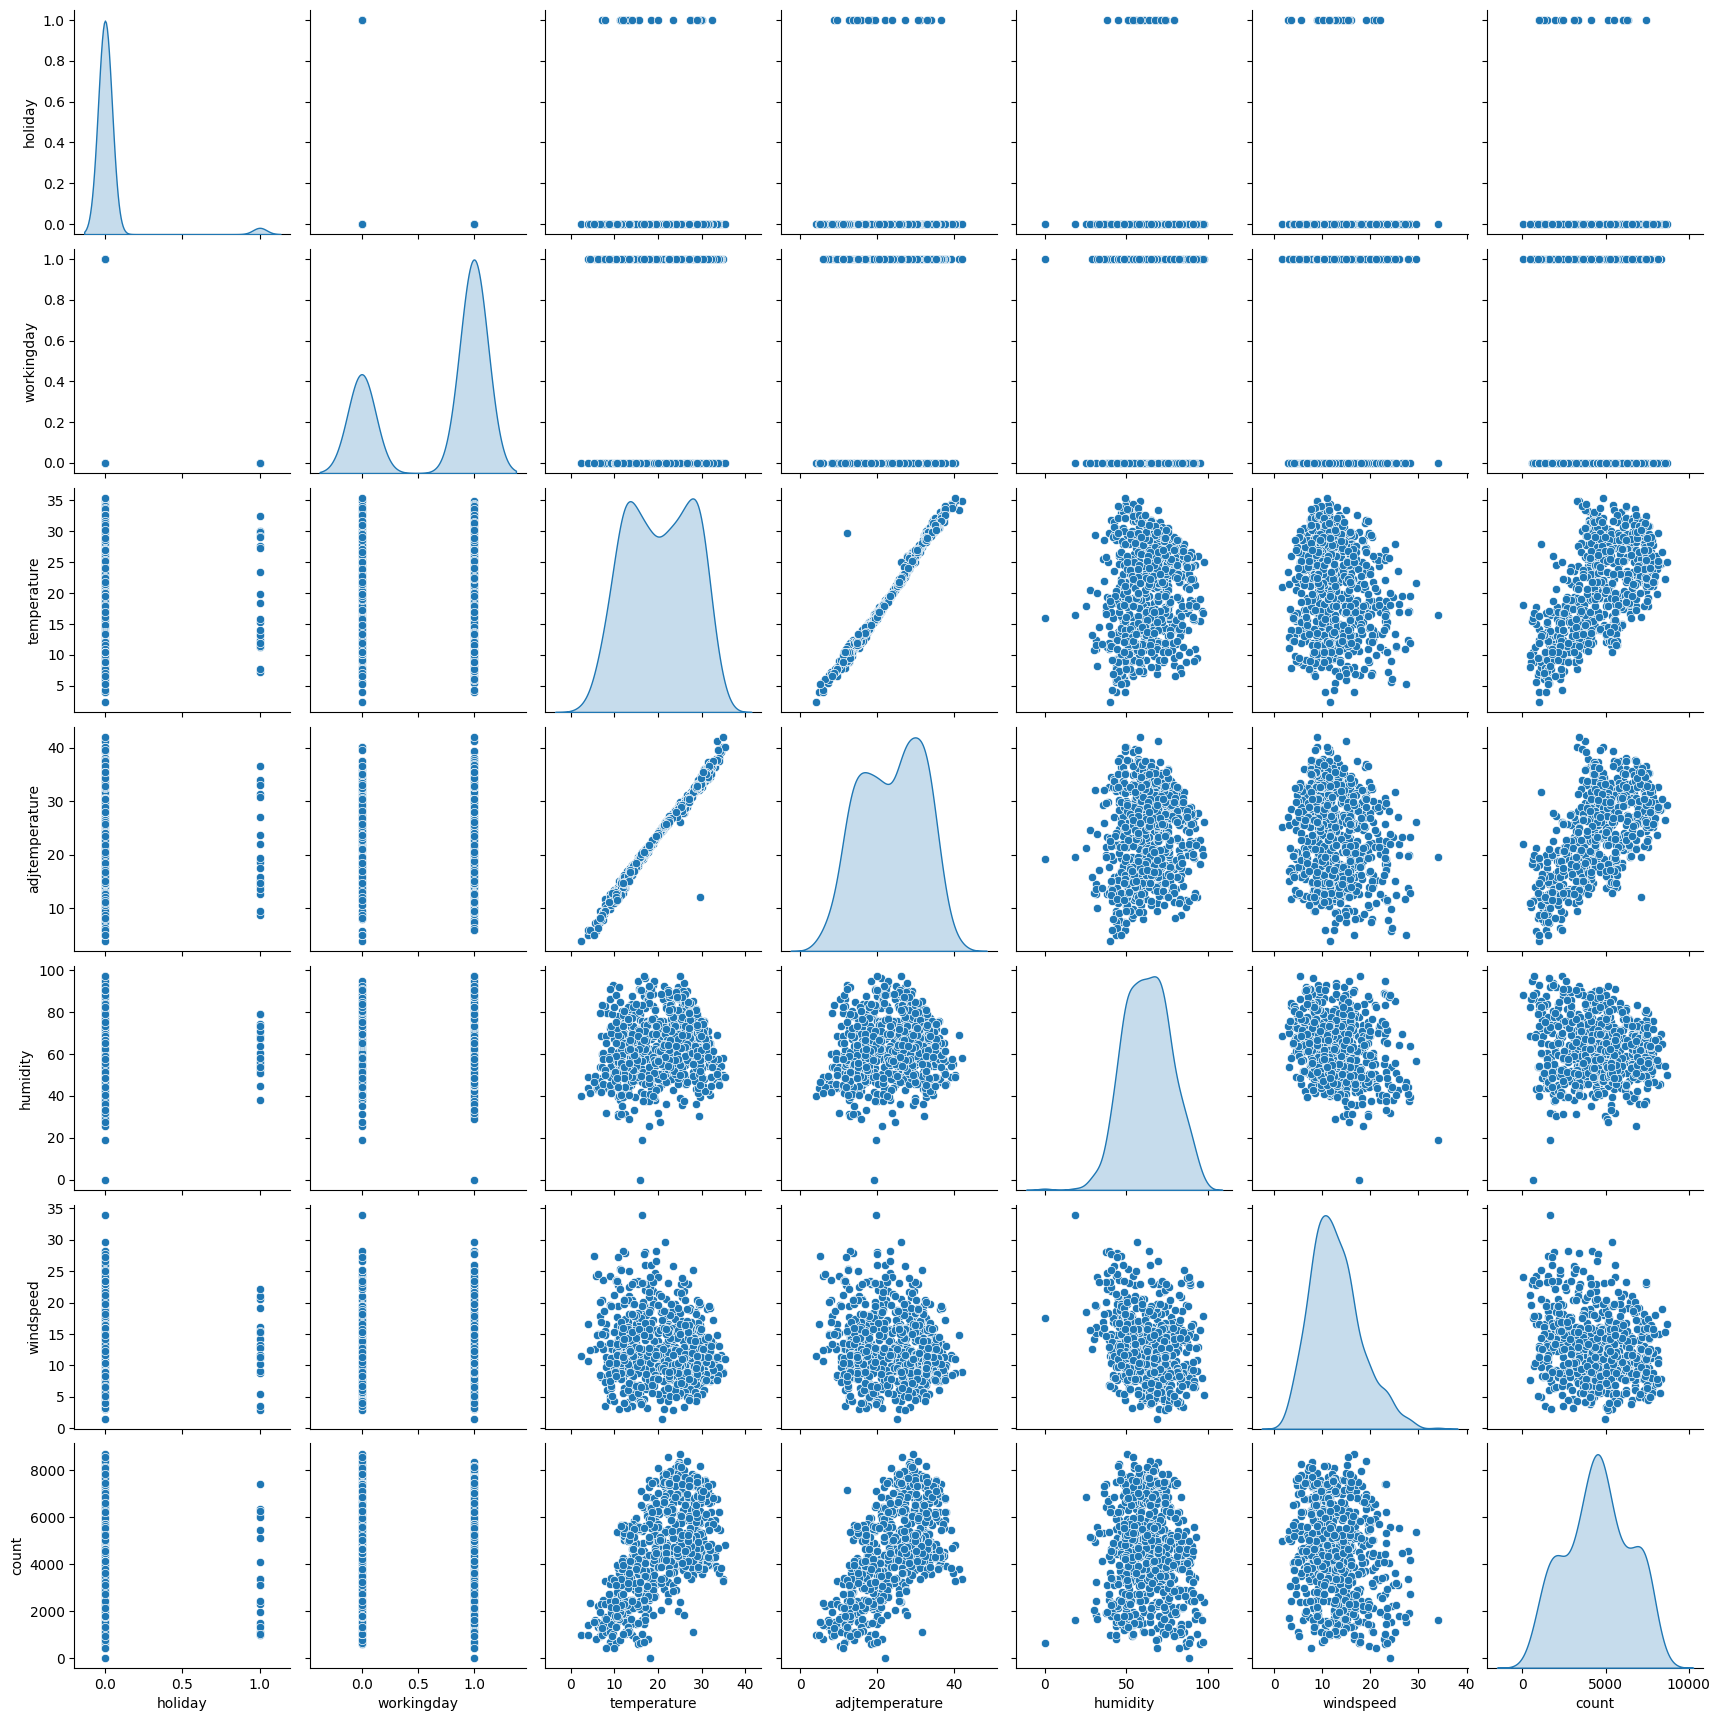

In [349]:
pair_plot(boom_bike)

**Summary**

1. For Count variable we can see temperature and atemperature are having linear regression
2. For clarity we will consider temperature, atemperature, humidity, windspeed, count variables in the next pair plot
3. And we can also see temperature and atemperature variable are almost similar graph for more clarification we will see in heat map


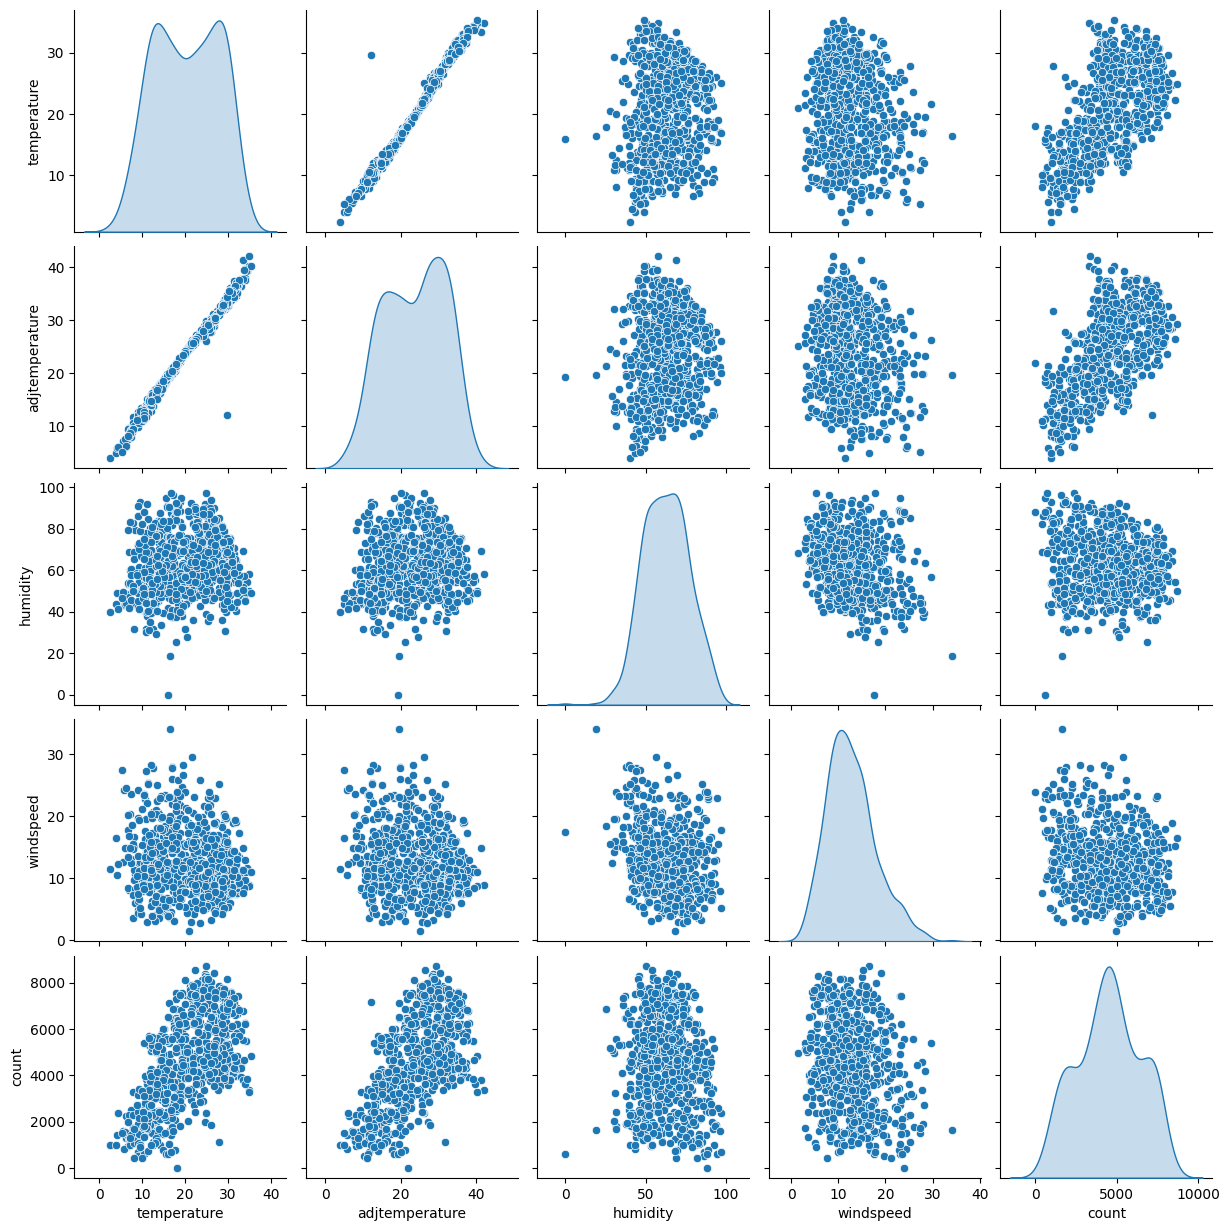

In [350]:
bike_data=boom_bike[['temperature', 'adjtemperature', 'humidity', 'windspeed','count']]

pair_plot(bike_data)

**Summary**:
1. This plot we have observed count (independent variable) is having linear relationship with temperature and adjtemperature variable (dependent variable)
2. temperature & adjtemperature are having multicollinearity between them, we can do this validation using heat map plot

In [351]:
def heat_map(dataframe):
    """
    Creates heat map on assigned columns.

    Args:
        data_frame: The pandas DataFrame containing the data for the plot.

    Returns:
        heat map
    """
    sns.heatmap(dataframe.corr(), annot=True)
    plt.show()

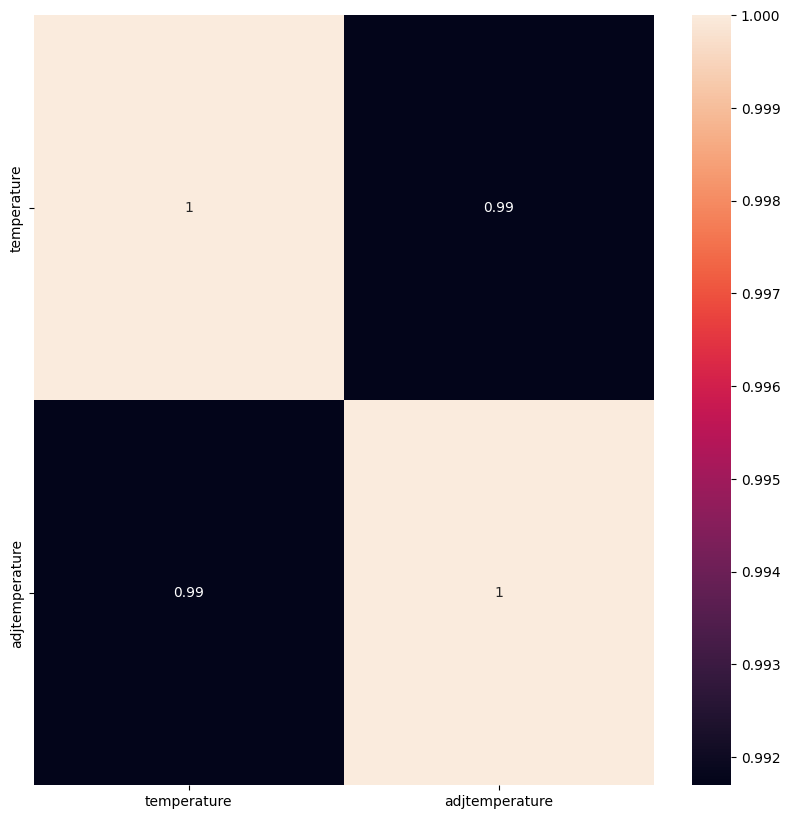

In [352]:
plt.figure(figsize=(10,10))
boom_data=boom_bike[['temperature', 'adjtemperature']]
heat_map(boom_data)

**Summary**

* In above heat map we can see there is high correlation between temperature and adjusted temperature

**## Creating dummy variables for all the categorical features**

* month
* Weekday
* season
* weathersit



In [353]:
boom_bike_dummy = pd.get_dummies(boom_bike, drop_first=True, dtype='int')
boom_bike_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   holiday                       730 non-null    int64  
 1   workingday                    730 non-null    int64  
 2   temperature                   730 non-null    float64
 3   adjtemperature                730 non-null    float64
 4   humidity                      730 non-null    float64
 5   windspeed                     730 non-null    float64
 6   count                         730 non-null    int64  
 7   season_spring                 730 non-null    int64  
 8   season_summer                 730 non-null    int64  
 9   season_winter                 730 non-null    int64  
 10  year_2019                     730 non-null    int64  
 11  month_Aug                     730 non-null    int64  
 12  month_Dec                     730 non-null    int64  
 13  month

In [354]:
boom_bike_dummy_corr = boom_bike_dummy.corr()
boom_bike_dummy_corr

,holiday,workingday,temperature,adjtemperature,humidity,windspeed,count,season_spring,season_summer,season_winter,year_2019,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light rain & snow,weathersit_mist & cloudy
holiday,1.000,-0.253,-0.029,-0.033,-0.016,0.006,-0.069,0.035,-0.024,0.017,0.008,-0.052,0.006,0.012,0.036,0.006,-0.052,-0.052,0.006,0.068,0.006,0.008,0.280,-0.071,-0.071,-0.023,-0.047,-0.046,-0.030,-0.019
workingday,-0.253,1.000,0.053,0.053,0.023,-0.019,0.063,-0.028,0.015,-0.005,-0.003,0.038,-0.015,-0.003,-0.025,-0.015,0.021,0.028,0.007,-0.011,-0.004,-0.011,0.153,-0.602,-0.602,0.260,0.269,0.267,0.029,0.049
temperature,-0.029,0.053,1.000,0.992,0.129,-0.158,0.627,-0.619,0.155,-0.226,0.049,0.355,-0.286,-0.311,-0.432,0.433,0.308,-0.175,0.165,-0.207,-0.018,0.198,-0.005,-0.030,-0.027,0.019,0.019,0.023,-0.058,-0.096
adjtemperature,-0.033,0.053,0.992,1.000,0.142,-0.184,0.631,-0.625,0.163,-0.206,0.047,0.331,-0.277,-0.311,-0.439,0.429,0.301,-0.173,0.170,-0.197,-0.005,0.192,0.000,-0.031,-0.023,0.020,0.022,0.021,-0.065,-0.093
humidity,-0.016,0.023,0.129,0.142,1.000,-0.249,-0.099,-0.185,-0.003,0.164,-0.113,0.022,0.082,-0.131,-0.090,-0.064,-0.109,-0.084,0.131,-0.006,0.142,0.183,0.029,-0.023,0.000,-0.052,0.041,0.046,0.268,0.491
windspeed,0.006,-0.019,-0.158,-0.184,-0.249,1.000,-0.235,0.179,0.097,-0.136,-0.012,-0.069,-0.055,0.096,0.062,-0.096,-0.020,0.127,-0.030,-0.026,-0.060,-0.095,0.001,0.032,-0.010,0.006,0.007,-0.014,0.117,-0.037
count,-0.069,0.063,0.627,0.631,-0.099,-0.235,1.000,-0.562,0.145,0.065,0.570,0.182,-0.174,-0.274,-0.367,0.166,0.196,-0.128,0.133,-0.040,0.109,0.195,-0.036,0.009,-0.059,0.034,0.001,0.014,-0.241,-0.171
season_spring,0.035,-0.028,-0.619,-0.625,-0.185,0.179,-0.562,1.000,-0.332,-0.325,0.000,-0.174,0.077,0.504,0.533,-0.174,-0.171,0.282,-0.174,-0.171,-0.174,-0.171,0.001,0.010,0.010,-0.006,-0.006,-0.013,-0.022,0.029
season_summer,-0.024,0.015,0.155,0.163,-0.003,0.097,0.145,-0.332,1.000,-0.330,0.000,-0.177,-0.177,-0.167,-0.177,-0.177,0.286,0.072,0.525,-0.174,-0.177,-0.174,0.005,-0.004,-0.004,-0.002,-0.002,0.009,-0.043,0.040
season_winter,0.017,-0.005,-0.226,-0.206,0.164,-0.136,0.065,-0.325,-0.330,1.000,-0.000,-0.173,0.285,-0.164,-0.173,-0.173,-0.170,-0.173,-0.173,0.527,0.536,0.016,0.004,-0.005,0.004,-0.003,0.006,-0.001,0.093,0.034


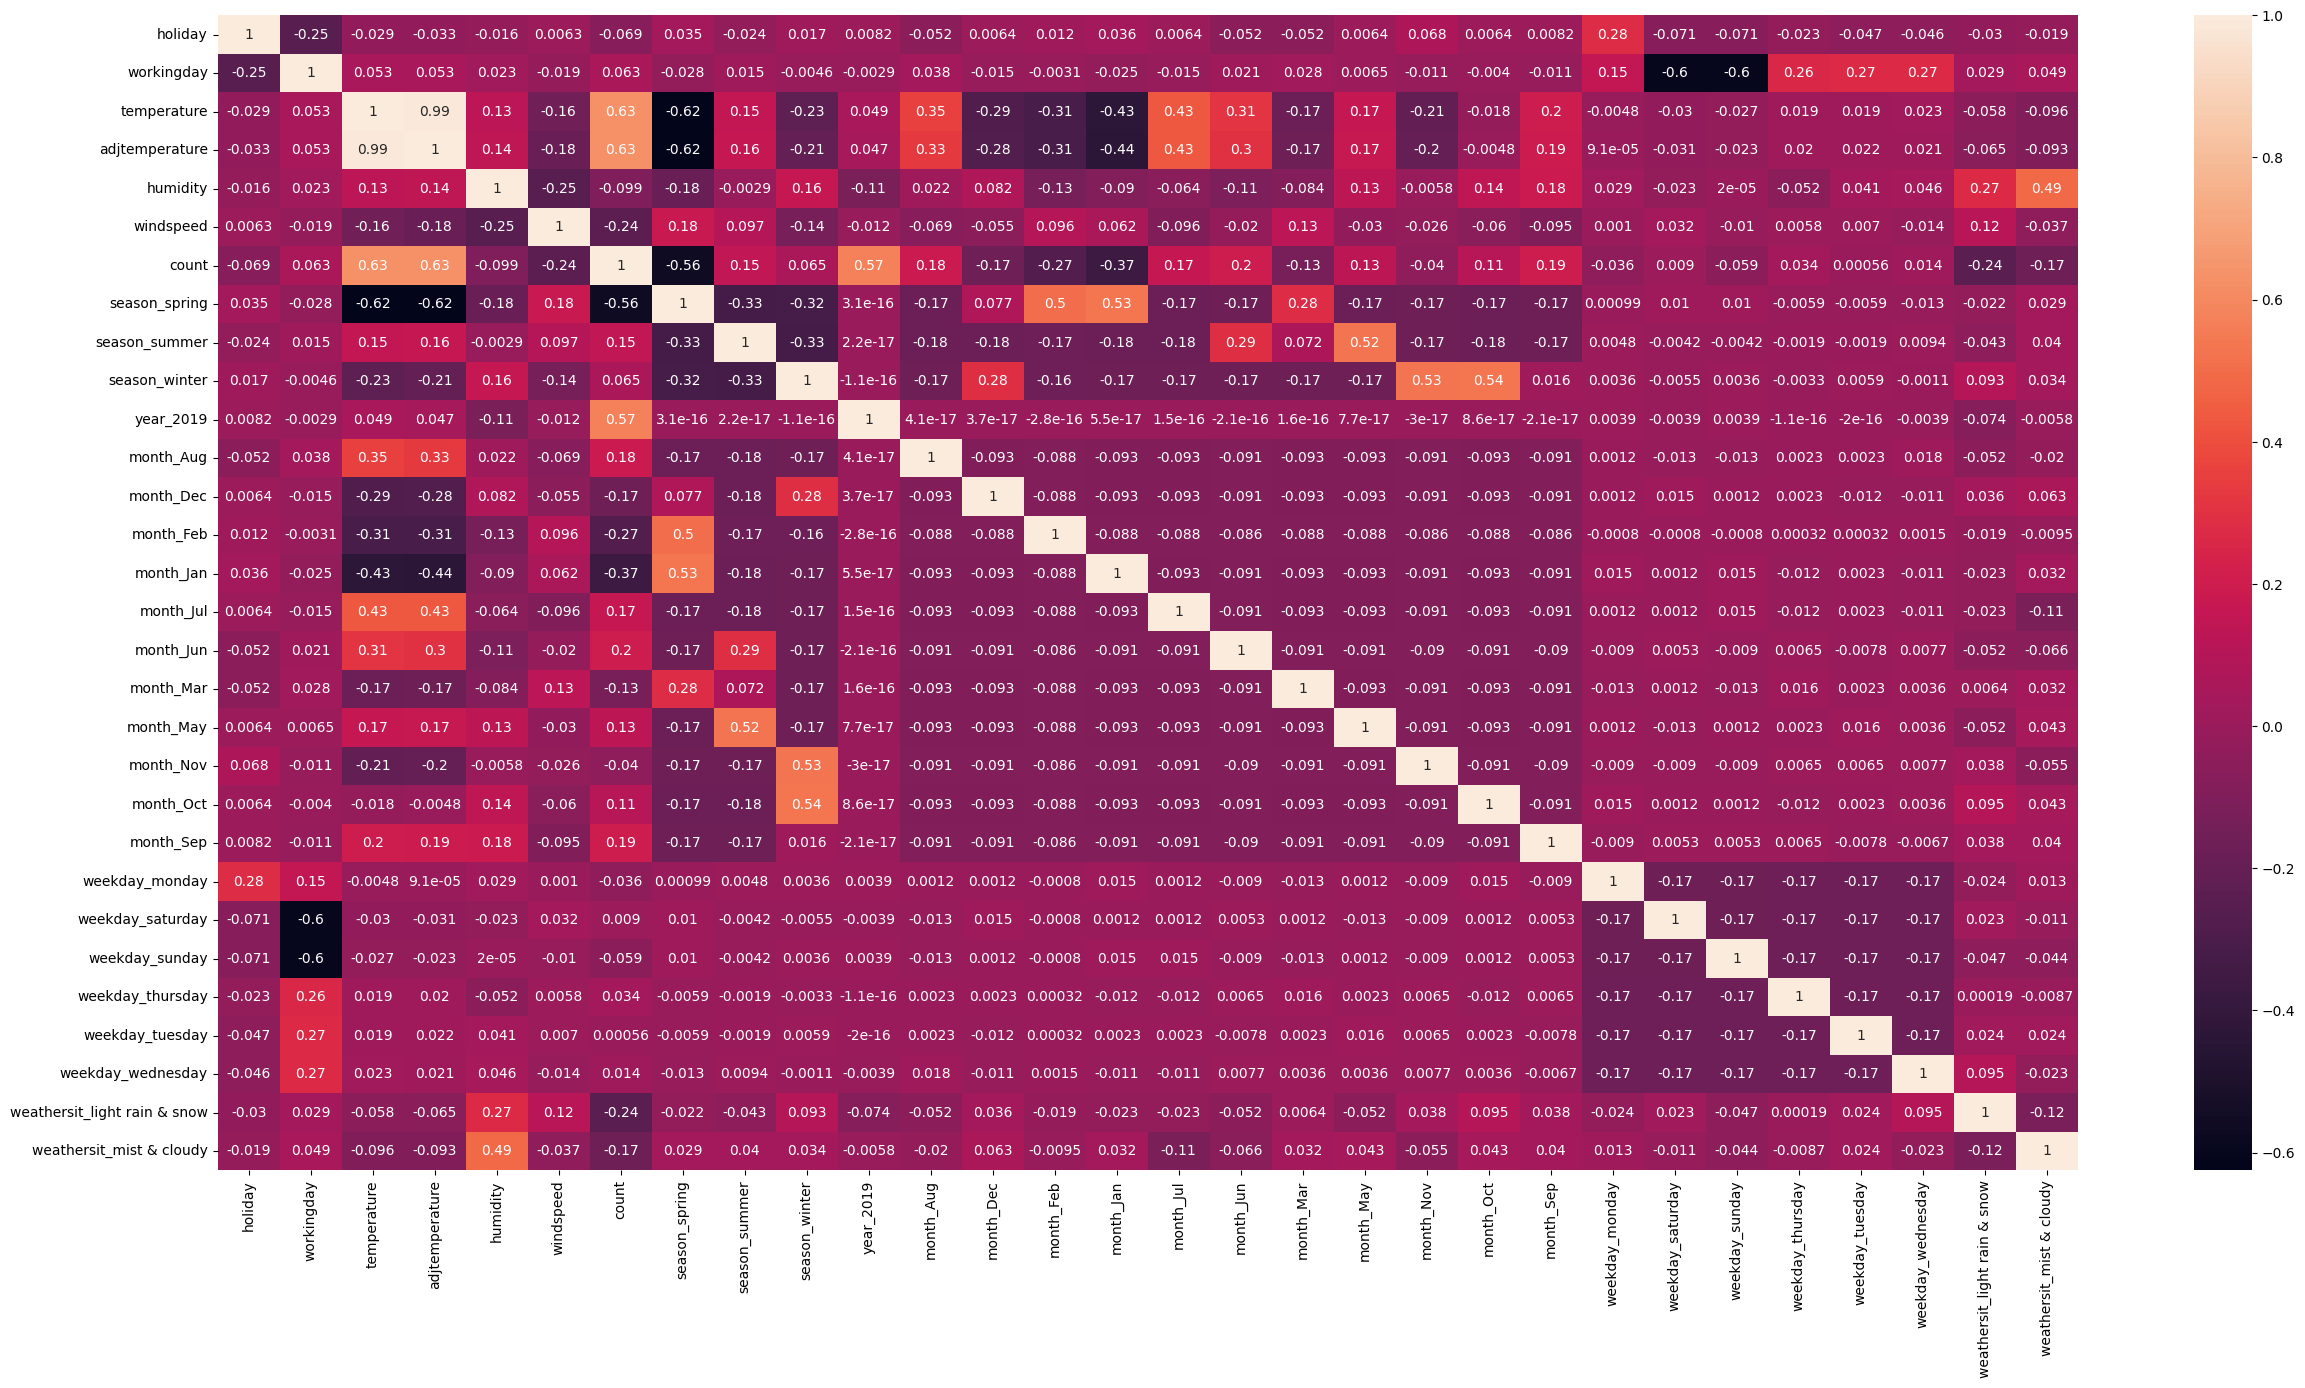

In [355]:
plt.figure(figsize=(30,15))
heat_map(boom_bike_dummy)

**Summary**

* Above heat map help us to understand which variables are high collinearity with target variable (Count), we will consider this heap map while building the linear model
* To validate different correlated values along with VIF and p-values which would help us to identifying the correct variable to select/eliminate from the model

### **Split the data into Train and Test data set**

In [356]:
boom_bike_train, boom_bike_test = train_test_split(boom_bike_dummy, train_size=0.7,
                                                   test_size=0.3, random_state=100)

In [357]:
dataFrame_properties(boom_bike_test, null_check_percentage = 50)

******************** DataFrame Shape ********************
(219, 30) 

******************** DataFrame Top Five Records ********************
     holiday  workingday  temperature  adjtemperature  humidity  windspeed  \
184        1           0       29.793          33.271    63.792      5.459   
535        0           1       32.083          36.049    59.208      7.625   
299        0           1       19.270          22.852    81.292     13.250   
221        0           1       31.433          34.249    42.417     13.417   
152        0           1       29.315          32.197    30.500     19.583   

     count  season_spring  season_summer  season_winter  year_2019  month_Aug  \
184   6043              0              0              0          0          0   
535   6211              0              1              0          1          0   
299   2659              0              0              1          0          0   
221   4780              0              0              0          0  

In [358]:
dataFrame_properties(boom_bike_train, null_check_percentage = 50)

******************** DataFrame Shape ********************
(510, 30) 

******************** DataFrame Top Five Records ********************
     holiday  workingday  temperature  adjtemperature  humidity  windspeed  \
653        0           1       19.202          23.042    55.833     12.209   
576        0           1       29.247          33.145    70.417     11.083   
426        0           0       16.981          20.675    62.125     10.792   
728        0           0       10.489          11.585    48.333     23.501   
482        0           0       15.443          18.875    48.958      8.708   

     count  season_spring  season_summer  season_winter  year_2019  month_Aug  \
653   7534              0              0              1          1          0   
576   7216              0              0              0          1          0   
426   4066              1              0              0          1          0   
728   1796              1              0              0          1  

### **Scaling Train and Test Data set**

In [359]:
scale = MinMaxScaler()

In [360]:
numerical_variables = ['temperature', 'adjtemperature', 'humidity', 'windspeed', 'count']
boom_bike_train[numerical_variables] = scale.fit_transform(
    boom_bike_train[numerical_variables])
boom_bike_test[numerical_variables] = scale.transform(
    boom_bike_test[numerical_variables])

In [361]:
boom_bike_train.describe()

,holiday,workingday,temperature,adjtemperature,humidity,windspeed,count,season_spring,season_summer,season_winter,year_2019,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light rain & snow,weathersit_mist & cloudy
count,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000,510.000
mean,0.025,0.676,0.537,0.513,0.650,0.321,0.514,0.243,0.245,0.249,0.508,0.096,0.084,0.067,0.088,0.076,0.075,0.098,0.084,0.086,0.086,0.080,0.151,0.155,0.143,0.133,0.131,0.159,0.029,0.343
std,0.158,0.468,0.226,0.212,0.146,0.170,0.225,0.429,0.431,0.433,0.500,0.295,0.278,0.250,0.284,0.266,0.263,0.298,0.278,0.281,0.281,0.272,0.358,0.362,0.351,0.340,0.338,0.366,0.169,0.475
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.340,0.332,0.539,0.199,0.356,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,1.000,0.541,0.527,0.654,0.297,0.519,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,1.000,0.735,0.688,0.755,0.414,0.685,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### **Defining Target & Feature variables**

In [362]:
y_train = boom_bike_train.pop('count')
X_train = boom_bike_train

In [363]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [364]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temperature', True, 1),
 ('adjtemperature', False, 6),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 4),
 ('season_winter', True, 1),
 ('year_2019', True, 1),
 ('month_Aug', False, 8),
 ('month_Dec', False, 3),
 ('month_Feb', False, 5),
 ('month_Jan', True, 1),
 ('month_Jul', True, 1),
 ('month_Jun', False, 14),
 ('month_Mar', False, 15),
 ('month_May', False, 7),
 ('month_Nov', True, 1),
 ('month_Oct', False, 11),
 ('month_Sep', True, 1),
 ('weekday_monday', False, 9),
 ('weekday_saturday', True, 1),
 ('weekday_sunday', False, 2),
 ('weekday_thursday', False, 12),
 ('weekday_tuesday', False, 10),
 ('weekday_wednesday', False, 13),
 ('weathersit_light rain & snow', True, 1),
 ('weathersit_mist & cloudy', True, 1)]

**Summary**

* We considered top 15 preditors which will impact our outcome, but we will validate those 15 features manually by building model and will eliminate the features which does not fulfill our requirements



In [365]:
support_columns = X_train.columns[rfe.support_].sort_values()
print(support_columns)

Index(['holiday', 'humidity', 'month_Jan', 'month_Jul', 'month_Nov',
       'month_Sep', 'season_spring', 'season_winter', 'temperature',
       'weathersit_light rain & snow', 'weathersit_mist & cloudy',
       'weekday_saturday', 'windspeed', 'workingday', 'year_2019'],
      dtype='object')


In [366]:
not_support_columns = X_train.columns[~rfe.support_].sort_values
print(not_support_columns)

<bound method Index.sort_values of Index(['adjtemperature', 'season_summer', 'month_Aug', 'month_Dec',
       'month_Feb', 'month_Jun', 'month_Mar', 'month_May', 'month_Oct',
       'weekday_monday', 'weekday_sunday', 'weekday_thursday',
       'weekday_tuesday', 'weekday_wednesday'],
      dtype='object')>


In [367]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[support_columns]

**VIF & Model creation**

In [368]:
def VIF_calculation(dataframe_rfe):
    """
    Gives the Variance Inflation Factor values of each features.

    Args:
        dataframe_rfe: The pandas DataFrame containing the data.

    Returns:
        Dataframe with VIF values.
    """
    vif = pd.DataFrame()
    vif['Features'] = dataframe_rfe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe_rfe.values, i)
                  for i in range(dataframe_rfe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
  #  vif_df = vif_df.reset_index(drop=True)
    return vif


def linear_regression(dataframe_rfe):
    """
    Gives the linear regression details of dataframe_rfe.

    Args:
        dataframe_rfe: The pandas DataFrame containing the data.

    Returns:
        Summary & predict result.
    """
    # Add a constant
    X_train_lm = sm.add_constant(dataframe_rfe)

    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    #lr.params
    y_train_pred_result = lr.predict(X_train_lm)
    #print(lr.summary())
    return y_train_pred_result, lr.summary()


### ***Model 1***

In [369]:
vif = VIF_calculation(X_train_rfe)
vif

,Features,VIF
1,humidity,24.120
8,temperature,16.810
13,workingday,5.210
12,windspeed,4.200
6,season_spring,2.980
7,season_winter,2.610
10,weathersit_mist & cloudy,2.240
14,year_2019,2.070
11,weekday_saturday,1.950
2,month_Jan,1.670


In [370]:
y_train_pred,lrsummary = linear_regression(X_train_rfe)
print(lrsummary)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     181.2
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.12e-189
Time:                        19:17:33   Log-Likelihood:                 515.86
No. Observations:                 510   AIC:                            -999.7
Df Residuals:                     494   BIC:                            -932.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Summary**
*  We have to drop `month_Nov` because p value is not significate and greater than 0.05 but VIF value is 1.59 which less the 5 still we have to drop this feature
*  we will considered `temperature` variable because in pair plot we saw it is having linear graph and in the heat map correlation is 0.63

### ***Model 2***

In [371]:
X_train_rfe = X_train_rfe.drop(["month_Nov"], axis = 1)
vif = VIF_calculation(X_train_rfe)
vif

,Features,VIF
1,humidity,24.110
7,temperature,16.720
12,workingday,5.200
11,windspeed,4.170
5,season_spring,2.970
9,weathersit_mist & cloudy,2.230
6,season_winter,2.140
13,year_2019,2.070
10,weekday_saturday,1.950
2,month_Jan,1.670


In [372]:
y_train_pred,lrsummary = linear_regression(X_train_rfe)
print(lrsummary)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     193.0
Date:                Tue, 28 May 2024   Prob (F-statistic):          4.03e-190
Time:                        19:17:33   Log-Likelihood:                 514.17
No. Observations:                 510   AIC:                            -998.3
Df Residuals:                     495   BIC:                            -934.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Summary**:
* We have to drop `humidity` because p value is significate and less than 0.05 but VIF value is 24.110 which greater then 5 still we have to drop this feature

### ***Model 3***

In [373]:
X_train_rfe = X_train_rfe.drop(["humidity"], axis = 1)
vif = VIF_calculation(X_train_rfe)
vif

,Features,VIF
6,temperature,6.910
11,workingday,5.020
10,windspeed,4.160
4,season_spring,2.410
12,year_2019,2.070
9,weekday_saturday,1.920
1,month_Jan,1.620
8,weathersit_mist & cloudy,1.550
5,season_winter,1.490
2,month_Jul,1.370


In [374]:
y_train_pred,lrsummary = linear_regression(X_train_rfe)
print(lrsummary)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.3
Date:                Tue, 28 May 2024   Prob (F-statistic):          3.12e-188
Time:                        19:17:33   Log-Likelihood:                 506.90
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     496   BIC:                            -926.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Summary**:
* We have to drop `workingday` because p value is significate and less than 0.05 but VIF value is 5.020 which near to 5 still we have to drop this feature (We need to consider less the 5 VIF value)

### ***Model 4***

In [375]:
X_train_rfe = X_train_rfe.drop(["workingday"], axis = 1)
vif = VIF_calculation(X_train_rfe)
vif

,Features,VIF
6,temperature,4.670
10,windspeed,4.030
4,season_spring,2.250
11,year_2019,2.060
1,month_Jan,1.600
8,weathersit_mist & cloudy,1.530
5,season_winter,1.410
2,month_Jul,1.360
3,month_Sep,1.200
9,weekday_saturday,1.190


In [376]:
y_train_pred,lrsummary = linear_regression(X_train_rfe)
print(lrsummary)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     210.8
Date:                Tue, 28 May 2024   Prob (F-statistic):          3.83e-186
Time:                        19:17:33   Log-Likelihood:                 499.15
No. Observations:                 510   AIC:                            -972.3
Df Residuals:                     497   BIC:                            -917.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Summary**
*  We have to drop `weekday_saturday` because p value is not significate and greater than 0.05 but VIF value is 1.190 which less the 5 still we have to drop this feature

### ***Model 5***

In [377]:
X_train_rfe = X_train_rfe.drop(["weekday_saturday"], axis = 1)
vif = VIF_calculation(X_train_rfe)
vif

,Features,VIF
6,temperature,4.630
9,windspeed,4.000
4,season_spring,2.250
10,year_2019,2.060
1,month_Jan,1.600
8,weathersit_mist & cloudy,1.530
5,season_winter,1.400
2,month_Jul,1.360
3,month_Sep,1.200
7,weathersit_light rain & snow,1.080


In [378]:
y_train_pred,lrsummary = linear_regression(X_train_rfe)
print(lrsummary)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.7
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.13e-186
Time:                        19:17:33   Log-Likelihood:                 497.58
No. Observations:                 510   AIC:                            -971.2
Df Residuals:                     498   BIC:                            -920.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Summary**
*  We have to drop `month_Jan` because p value is significate and less than 0.05 and VIF value is 1.6 which less the 5 still we have to dropped this feature just to check is there any change in the R squared and adjusted R squared

### ***Model 6***

In [379]:
X_train_rfe = X_train_rfe.drop(["month_Jan"], axis = 1)
vif = VIF_calculation(X_train_rfe)
vif

,Features,VIF
5,temperature,4.600
8,windspeed,4.000
9,year_2019,2.060
3,season_spring,1.650
7,weathersit_mist & cloudy,1.510
4,season_winter,1.400
1,month_Jul,1.350
2,month_Sep,1.200
6,weathersit_light rain & snow,1.080
0,holiday,1.040


In [380]:
y_train_pred,lrsummary = linear_regression(X_train_rfe)
print(lrsummary)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Tue, 28 May 2024   Prob (F-statistic):          1.16e-186
Time:                        19:17:34   Log-Likelihood:                 494.70
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     499   BIC:                            -920.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

**Summary**:
*  After dropping `month_Jan` we saw very small change in the R squared and adjusted R squared and VIF values of remaning features are less than 5. So, there is no multicollinearity in the data

### **Error Values Distribution Plot**

In [381]:
def model_plot(y_train_pred):
    """
    Gives the plot of the model.

    Args:
        y_train_pred: y train predict details.

    Returns:
        Plot of Distribution, QQ, Homoscedasticity & Independance of Errors.
    """
    res = y_train - y_train_pred

    print("\nDistribution Plot\n")
    sns.distplot(res, bins=30)
    plt.title('Residual Error Terms', fontsize=15)
    plt.xlabel('Errors', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

    print("\nQQ Plot\n")
    sm.qqplot(res, fit=True, line='45')
    plt.xlabel('Theoretical Quantiles', fontsize=12)
    plt.show()

    print("\nHomoscedasticity\n")
    sns.regplot(x=y_train, y=y_train_pred, ci=None, color='blue')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.show()

    print("\nIndependance of Errors\n")
    sns.regplot(x=y_train_pred, y=res, ci=None, color='blue')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()


Distribution Plot



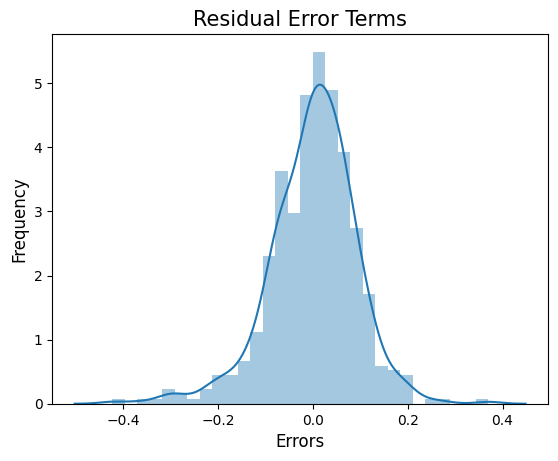


QQ Plot



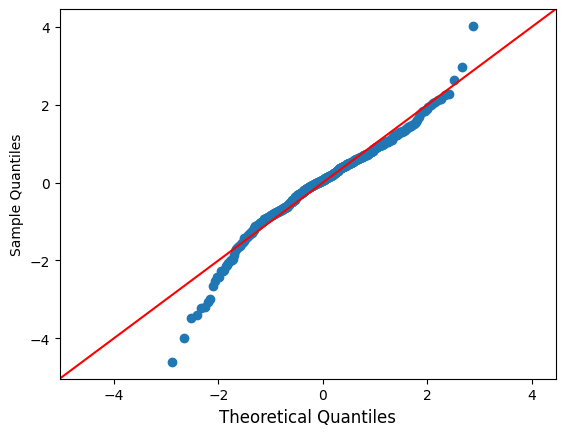


Homoscedasticity



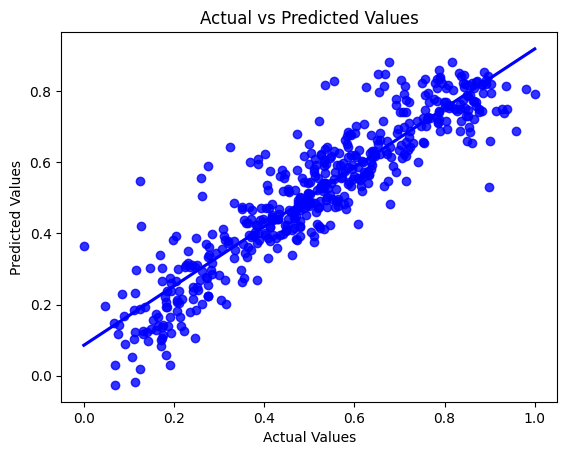


Independance of Errors



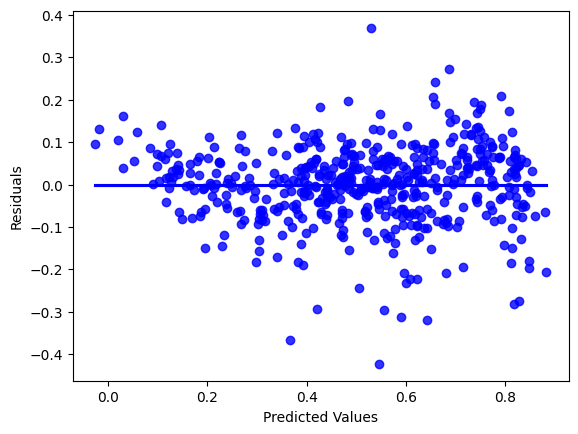

In [382]:
y_train_pred = model_plot(y_train_pred)

**Summary**:
* The distribution of residuals is approximately normal with a `Mean` near zero. However, some non-normality might be present
* There is no pattern in the homoscedasticity, because the variance of residuals across the predicted values
* Almost there is no relation between residual and predicted valies

### ***Test Data Analysis***

In [383]:
boom_bike_test.describe()

,holiday,workingday,temperature,adjtemperature,humidity,windspeed,count,season_spring,season_summer,season_winter,year_2019,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light rain & snow,weathersit_mist & cloudy
count,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000,219.000
mean,0.037,0.699,0.559,0.533,0.639,0.313,0.521,0.256,0.265,0.233,0.479,0.059,0.087,0.100,0.078,0.105,0.096,0.055,0.087,0.073,0.082,0.087,0.128,0.119,0.146,0.164,0.164,0.100,0.027,0.320
std,0.188,0.460,0.234,0.218,0.149,0.160,0.218,0.437,0.442,0.424,0.501,0.237,0.282,0.301,0.268,0.307,0.295,0.228,0.282,0.261,0.275,0.282,0.335,0.324,0.354,0.371,0.371,0.301,0.164,0.467
min,0.000,0.000,0.047,0.026,0.262,-0.043,0.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.355,0.345,0.527,0.199,0.378,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,1.000,0.559,0.549,0.628,0.299,0.524,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,1.000,0.759,0.714,0.744,0.403,0.673,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,1.000,1.000,0.984,0.981,1.002,0.807,0.963,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [384]:
y_test = boom_bike_test.pop('count')
X_test = boom_bike_test

In [385]:
def testdata_trainpredict(X_train_data, X_test_data):
    """
    Gives the plot of the y_test Vs y_test_predict.

    Args:
        X_train_data: Data set of train data (X).
        X_test_data: Data set of test data (X).

    Returns:
        Scatter Plot.
    """
    # Add a constant to train and test data set
    X_train_lm = sm.add_constant(X_train_data)
    X_test_lm = sm.add_constant(X_test_data)

    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()

    # Predict the test data set
    y_test_pred_data = lr.predict(X_test_lm)
    plt.scatter(y_test, y_test_pred_data, alpha=.5)
    plt.title('y_test vs y_test_pred', fontsize = 15)
    plt.xlabel('y_test', fontsize = 12)
    plt.ylabel('y_test_pred', fontsize = 12)
    plt.show()
    return y_test_pred_data

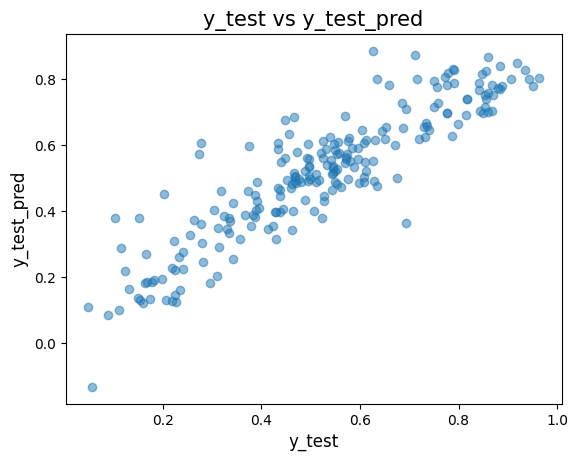

In [386]:
#Selecting the variables which are final in the last model
final_column = X_train_rfe.columns
X_test = X_test[final_column]

#testdata_trainpredict(X_train_rfe, X_test)
y_test_pred = testdata_trainpredict(X_train_rfe, X_test)

### **R^2 value (Test data set)**

In [387]:
r_square = r2_score(y_test, y_test_pred)
print(r_square)

0.8070101019557963


### **Adjusted R^2 value (Test data set)**

In [388]:
# n is number of rows in X
R2 = r_square
n = X_test.shape[0]

# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(((1-R2)*(n-1))/(n-p-1))
adjusted_r2

0.7977317414729018

## **Result of the Test and Train Data set**

1. Test Data:
  * R^2 value - `0.8070101019557963`
  * Adjusted R^2 value - `0.7977317414729018`
2. Train Data:
  * R^2 value - `0.833`
  * Adjusted R^2 value - `0.830`
3. Based on the R^2 and adjusted R^2 result of the test and train data set we can say this model is good because the difference between the R^2 is less than 5%

##**Final Equation**
y = `0.2519` + `0.4515` * temperature + `0.2341` * year_2019 + `0.0577` * month_Sep + `0.0473` * season_winter - `0.0727` * month_Jul - `0.0811` * weathersit_mist & cloudy - `0.0986` * holiday - `0.1108` * season_spring - `0.1398` * windspeed - `0.2864` * weathersit_light rain & snow

## **Interpretation of the Final Equation**

### Key Points from the Equation:

1. **Temperature (0.4515)**:
   - Positive coefficient indicates that as temperature increases, the demand for bikes increases.
   - Higher temperatures likely encourage more bike usage due to more comfortable riding conditions.

2. **Year 2019 (0.2341)**:
   - Positive coefficient suggests that demand was higher in 2019 compared to the baseline year (2018).
   - Reflects growing popularity and usage of bike-sharing services over time.

3. **Month September (0.0577)**:
   - Positive coefficient indicates higher demand in September.
   - September might have favourable weather conditions for biking or could coincide with specific events or back-to-school periods.

4. **Season Winter (0.0473)**:
   - Positive coefficient suggests a slight increase in demand during winter, which may seem counterintuitive, but could be due to specific promotions or mild winters in certain areas.

5. **Month July (-0.0727)**:
   - Negative coefficient indicates lower demand in July.
   - High temperatures or holiday periods might reduce bike usage.

6. **Weather Situation Mist & Cloudy (-0.0811)**:
   - Negative coefficient suggests that misty and cloudy conditions reduce bike demand.
   - Such weather conditions likely make biking less attractive.

7. **Holiday (-0.0986)**:
   - Negative coefficient shows a drop in bike demand on holidays.
   - People might have other leisure activities or travel plans that don't involve biking.

8. **Season Spring (-0.1108)**:
   - Negative coefficient indicates lower demand in spring.
   - This might be surprising, but could be due to specific local conditions or early spring weather.

9. **Windspeed (-0.1398)**:
   - Negative coefficient suggests that higher wind speeds reduce bike demand.
   - Windy conditions make biking more difficult and less enjoyable.

10. **Weather Situation Light Rain & Snow (-0.2864)**:
    - Strong negative coefficient indicates a significant drop in demand under light rain or snow.
    - These conditions are likely the least favourable for biking, deterring many users.

### **Overall Insights:**

- **Weather Impact**: Temperature has a strong positive effect on bike demand, while adverse weather conditions like wind, mist, cloudiness, and light rain/snow significantly reduce demand.
- **Seasonal and Monthly Variations**: There are notable variations in demand across different months and seasons, with some unexpected findings like increased winter demand and decreased spring demand, which might warrant further investigation.
- **Yearly Trend**: The increasing demand from 2018 to 2019 indicates the growing adoption of bike-sharing services.
- **Holidays**: Demand decreases during holidays, suggesting alternative leisure activities or travel plans.

These insights can help BoomBikes optimize their operations and marketing strategies by focusing on favourable weather conditions and understanding seasonal trends.